In [1]:
import numpy as np
import pandas as pd

import Quandl
from helpers import get_adj_close

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

import scipy.optimize as opt
from scipy import stats

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.graphics import tsaplots
from statsmodels.tsa import *

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%matplotlib inline
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon': True,
                            'axes.labelsize': 'small'})
#sns.set_context("talk")

In [3]:
basket = get_adj_close(['FB', 'AAPL'], start="2013-01-01", ratio=False)

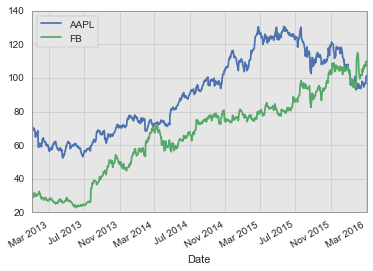

In [5]:
basket.plot()

In [48]:
# def get_lagged_returns(series):
#     """
#     Args:
#         series (ndarray): the time series to get the lagged return ratios
#         window_size (int): number of trading weeks to use
        
#     Return (ndarray): y(t)/y(t-1) over the weeks specified
#     """
    
#     return list(np.array(series[1:])/np.array(series[:-1]))

In [49]:
def get_lagged_returns(series, window_size):
    """
    Args:
        series (ndarray): the time series to get the lagged return ratios
        window_size (int): number of trading weeks to use
        
    Return (ndarray): y(t)/y(t-1) over the weeks specified
    """
    
    return series[-window_size*5:].values/series[-((window_size*5)+1):-1].values

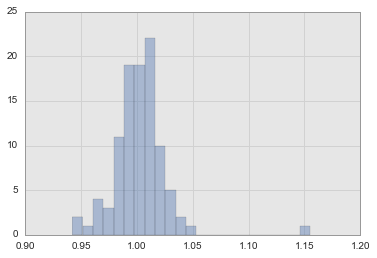

In [7]:
sns.distplot(get_lagged_returns(basket['FB'],20), kde=False);

In [8]:
# mu = 1
# sigma2 = 1
# x = np.random.lognormal(mu, np.sqrt(sigma2), 5000)

In [9]:
def neg_log_llh(theta, data):
    """
    Args:
        theta (list): the params [mu, sigma**2]
        data (ndarray): data points to be fit by log normal distribution
        
    Return (double): negative log-likelihood for the log normal.
    """
    
    mu, sigma = theta[0], np.sqrt(theta[1])
    neg_log_llhs = np.log(data*sigma*np.sqrt(2*np.pi)) + ((np.log(data)-mu)**2/(2*(sigma**2))) 
    
    return neg_log_llhs.sum()

In [10]:
def mle_log_norm(data, init_theta=[1,1]):
    """
    Args:
        theta (list): the params [mu, sigma**2]
        data (ndarray): data points to be fit by log normal distribution
    
    Return (list): mu, sigma**2 for fitted log normal params
    """
    
    fit = opt.minimize(neg_log_llh, init_theta, data, method='Nelder-Mead')
    return fit.x

In [11]:
mle_log_norm(get_lagged_returns(basket['FB'],20))

array([ 0.00169021,  0.00056446])

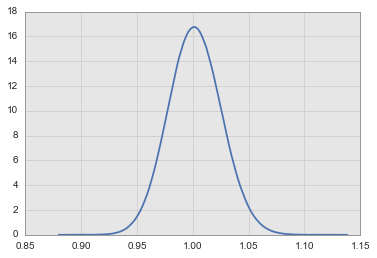

In [12]:
sns.distplot(np.random.lognormal(0.00169021, np.sqrt(0.00056446), 10000000), kde=True, hist=False);

In [13]:
def simulate_random_walk(series, window_size=10, ahead=50):
    """
    Args:
        series (ndarray): time series to use
        window_size (int): number of trading weeks to use for log normal estimation
        ahead (int): how many days do you want to forcast head for
    
    Return (ndarray): simulated future price
    """
    
    mu, sigma2 = mle_log_norm( get_lagged_returns(series, window_size) )
    
    forcast = np.random.lognormal(mu, np.sqrt(sigma2), ahead)
    forcast[0] *= series[-1:]
    
    return np.cumprod(forcast)

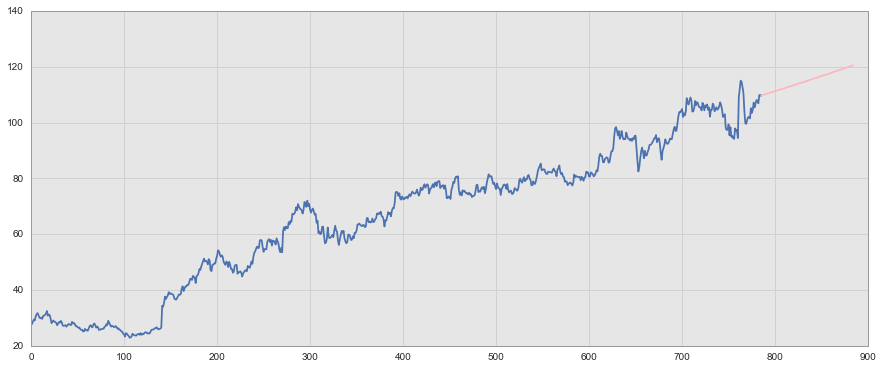

In [60]:
plt.figure(figsize=(15,6))
plt.plot(np.arange(0,basket.FB.count()), basket.FB)
# for i in range(10):
#     plt.plot(np.arange(785, 885), simulate_random_walk(basket.FB, 50, 100), 'lightpink')
plt.plot(np.arange(785, 885), get_expected_forcast(basket.FB, 10, 100), 'lightpink')

In [59]:
def get_expected_forcast(series, window_size, ahead):
    
    mu, sigma2 = mle_log_norm( get_lagged_returns(series, window_size) )
    forcast = [np.exp((mu+sigma2)/2) for _ in range(ahead)]
    forcast[0] *= series[-1:]
    
    return np.cumprod(forcast)

In [16]:
def plot_correlograms(series, limit=50):
    fig = plt.figure(figsize=(10,6));
    ax1 = fig.add_subplot(211);
    fig = sm.graphics.tsa.plot_acf(series, lags=limit, ax=ax1);
    plt.title('Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])
    
    ax2 = fig.add_subplot(212);
    fig = sm.graphics.tsa.plot_pacf(series, lags=limit, ax=ax2);
    plt.title('Partial Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])

In [17]:
# def moving_average(ts, theta1):
#     ma = pd.Series(index=ts.index, data=np.repeat(0, ts.size))
#     ma[0] = ts[0]
  
#     for idx in range(1,ts.size):
#         ma[idx] = theta1*ts[idx-1]
      
#     return ma

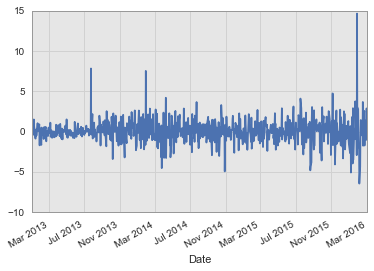

In [36]:
basket.FB.diff(1).dropna().plot();

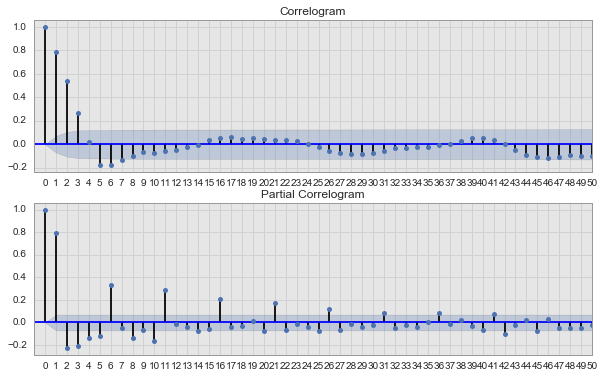

In [31]:
plot_correlograms(basket.FB.diff(1).dropna());

In [78]:
arima1 = arima_model.ARIMA(basket.FB, order=[0,2,1]).fit()

In [79]:
arima1.params

const          0.000055
ma.L1.D2.FB   -0.999964
dtype: float64

In [80]:
resid = arima1.resid

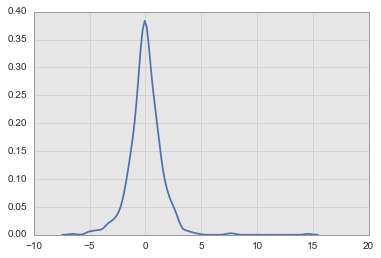

In [81]:
sns.kdeplot(resid);

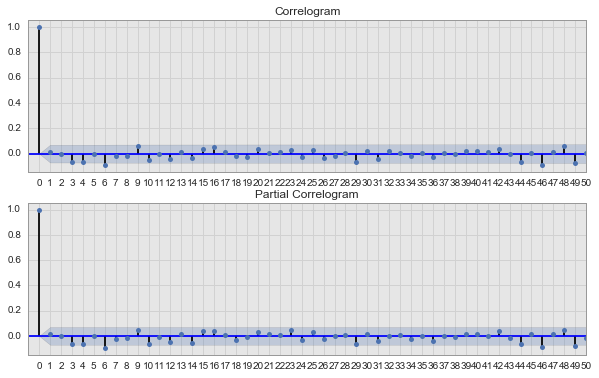

In [82]:
plot_correlograms(resid)

In [83]:
predict = arima1.predict('2014', '2015', dynamic=True)

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


In [84]:
predict.head()

2014-12-31    1.675308
2015-01-02    0.000055
2015-01-05    0.000055
2015-01-06    0.000055
2015-01-08    0.000055
dtype: float64